In [ ]:
!python3 -m pip install hypnettorch

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from HyperNet import CustomHyperNet, CustomHyperConvLayer
from MNISTModel import MNISTHyperNetModel, StandardCNNModel
import matplotlib.pyplot as plt

from IPython.display import display, Markdown, Latex
import numpy as np
from torch import nn
from hypnettorch.data import MNISTData
from hypnettorch.mnets import MLP
import sys
import traceback


# HYPERNETWORK

### INTRODUCTIOIN

**Hipernetworki** lub w skrócie **hipernety** to sieci neuronowe, które generują wagi dla innej sieci neuronowej, znanej jako sieć docelowa.

Kluczowe cechy i zalety hipernetów, które oferują aplikacje w różnych ustawieniach problemów:

* Soft weight sharing: Hipernetworki można trenować do generowania wag wielu DNN do rozwiązywania powiązanych zadań.

* Dynamic architectures: Hipernetworki mogą być używane do generowania wag sieci o architekturze dynamicznej, w której liczba warstw lub struktura sieci zmienia się podczas szkolenia lub wnioskowania. Może to być szczególnie przydatne w przypadku zadań, w których docelowa struktura sieci nie jest znana w czasie szkolenia.

* Data-adaptive DNN: w przeciwieństwie do standardowego DNN, którego wagi są ustalane w czasie wnioskowania, HyperDNN można opracować w celu generowania sieci docelowej dostosowanej do potrzeb danych. W takich przypadkach hipernety są uwarunkowane danymi wejściowymi w celu dostosowania się do danych.

* Uncertainty quantification: Hipernety mogą skutecznie trenować DNN ktore świadome o niepewności, wykorzystując techniki jak multiple inputs z rozkładu szumów lub włączenie przerywania w hipernetach sami.

* Parameter efficiency: DNN przeszkolony w hipernetach może mieć mniej wag niż
standardowe DNNs, powodujące z kompresji wag. Może to być szczególnie przydatne, gdy
cos dziala z ograniczonymi zasobami, ograniczonymi danymi lub w przypadku danych o dużych wymiarach i może skutkować szybszy trening niż zlykle DNN.

### ARCHITECTURE

#### Main Network

**Struktura i rola**: Main Network to typowa sieć neuronowa, którą można zaprojektować do dowolnego zadania głębokiego uczenia, takiego jak klasyfikacja obrazu, przetwarzanie języka naturalnego lub inne zadania. Struktura tej sieci może się różnić w zależności od konkretnego zadania: może to być splotowa sieć neuronowa (CNN) do przetwarzania obrazu, powtarzająca się sieć neuronowa (RNN) do przetwarzania sekwencji danych i tak dalej.

**Uczenie**: w normalnej sytuacji wagi tej sieci są inicjowane losowo, a następnie optymalizowane w procesie uczenia się, aby rozwiązać dany problem.

#### Hypernetwork

**Struktura i rola**: Hypernetwork to oddzielna sieć neuronowa, której celem jest generowanie wag dla sieci głównej. Ta sieć jest zwykle mniejsza i może być zaprojektowana tak, aby uwzględniać pewne cechy zadania, do którego szkolona jest sieć główna.

**Interakcja z primary network**: Hypernetwork pobiera dane wejściowe, które mogą zawierać informacje o stanie lub strukturze sieci głównej i na podstawie tych danych generuje wagi dla sieci głównej. 

In [2]:
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += output.argmax(dim=1).eq(target).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = 100. * total_correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} \tLoss: {avg_loss:.6f} \tAccuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [4]:
def test(model, device, test_loader):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.nll_loss(output, target, reduction='sum').item()
            total_correct += output.argmax(dim=1).eq(target).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = 100. * total_correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_loss:.4f}, Accuracy: {total_correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return avg_loss, accuracy


In [5]:
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()

    plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTHyperNetModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader, test_loader = load_data()

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

In [7]:
for epoch in range(1, 11):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Train Epoch: 1 	Loss: 0.009186 	Accuracy: 88.04%

Test set: Average loss: 0.1349, Accuracy: 9571/10000 (95.71%)

Train Epoch: 2 	Loss: 0.001882 	Accuracy: 96.26%

Test set: Average loss: 0.0986, Accuracy: 9666/10000 (96.66%)

Train Epoch: 3 	Loss: 0.001376 	Accuracy: 97.27%

Test set: Average loss: 0.0810, Accuracy: 9751/10000 (97.51%)

Train Epoch: 4 	Loss: 0.001151 	Accuracy: 97.75%

Test set: Average loss: 0.0759, Accuracy: 9755/10000 (97.55%)

Train Epoch: 5 	Loss: 0.000967 	Accuracy: 98.04%

Test set: Average loss: 0.0667, Accuracy: 9806/10000 (98.06%)

Train Epoch: 6 	Loss: 0.000881 	Accuracy: 98.27%

Test set: Average loss: 0.0799, Accuracy: 9768/10000 (97.68%)

Train Epoch: 7 	Loss: 0.000787 	Accuracy: 98.44%

Test set: Average loss: 0.0775, Accuracy: 9805/10000 (98.05%)

Train Epoch: 8 	Loss: 0.000742 	Accuracy: 98.53%

Test set: Average loss: 0.0641, Accuracy: 9797/10000 (97.97%)

Train Epoch: 9 	Loss: 0.000665 	Accuracy: 98.67%

Test set: Average loss: 0.0897, Accuracy: 9767

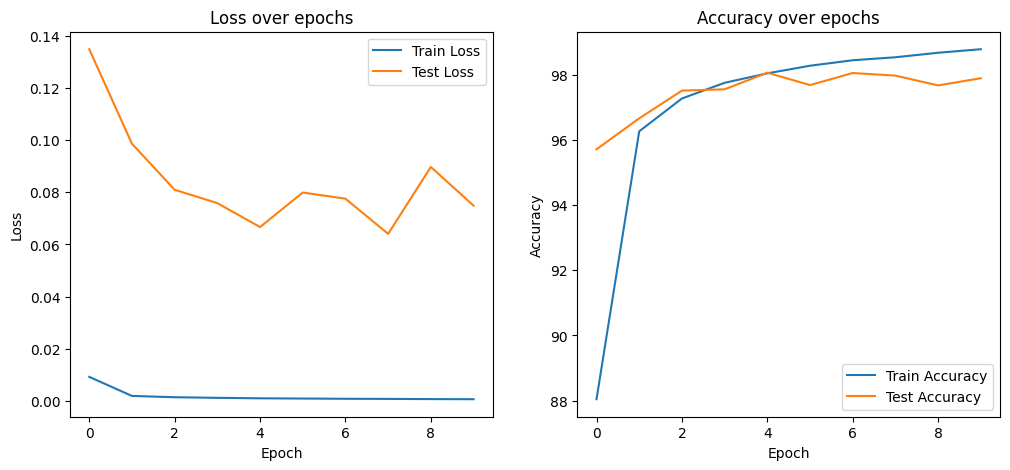

In [8]:
plot_results(train_losses, train_accuracies, test_losses, test_accuracies)

## Zadanie 1

Wytrenowac model MNISTHyperNetModel na Fashion MNIST i wyświetlaj przebiegu uczenia.

## Zadanie 2

Spróbuj opisać hypernet który został użyty w przykładzie MNISTHyperNetModel według kryteriów które są opisane w części "Categorisation of Hypernetworks"

## Zadanie 3

Zmodyfikować MNISTHyperNetModel tak, aby pierwsza warstwa konwolucyjna wykorzystywała wag wygenerowanych przez hypernet, a druga warstwa konwolucyjna wykorzystywała wagi wygenerowane w zwykły sposób. Wytrenować starą i nową modeli na MNIST i porównać  wyniki obu modeli.

## Categorisation of Hypernetworks

Istnieje podział na 5 kryteriów projektowania hipersieci:
- input-based 
- output-based
- variability of inputs 
- variability of outputs
- architecture-based

Za pomocą każdego z nich możemy lepiej zrozumieć działanie konkretnej hipersieci odpowiadając na pytania:

![categorisation.png](./imgs/categorisation.png)

### Input-based hypernetworks

Hypernetworki przyjmują wektor kontekstowy jako dane wejściowe i generują wagi docelowej sieci DNN jako wyjście. W zależności od użytego wektora kontekstowego możemy wyróżnić następujące typy hypernetworks:

- **Task-conditioned hypernetworks**: Te sieci przyjmują informacje specyficzne dla zadania jako dane wejściowe. Sieć generuje wagi dostosowane do konkretnego zadania, co pozwala na dostosowanie jej zachowania i współdzielenie informacji między zadaniami.

- **Data-conditioned hypernetworks**: Te sieci są warunkowane danymi, na których szkolona jest docelowa sieć. Sieć generuje wagi na podstawie charakterystyki danych wejściowych, co pozwala na dynamiczną adaptację modelu do konkretnych wzorców lub cech.

- **Noise-conditioned hypernetworks**: Te sieci nie są warunkowane żadnymi danymi wejściowymi ani wskazówkami zadania, a raczej losowo wybranym szumem. Sprawia to, że są bardziej uniwersalne i pomagają w kwantyfikacji niepewności predykcyjnej dla DNN.

### Output-based Hypernetworks

W zależności od sposobu generowania wag, czyli strategii generacji wag, klasyfikujemy hypernetworki na te, które generują wszystkie wagi naraz, i te, które tego nie robią. 

- **Generate Once**: Te sieci generują wagi całej docelowej sieci DNN naraz. Wszystkie wygenerowane wagi są używane, a wagi każdej warstwy są generowane razem.

- **Generate Multiple**: Te sieci mają wiele wyjsc do produkcji wag i ta metoda generowania wag może uzupełniać inne podejścia. Upraszcza to złożoność i redukuje liczbę wag wymaganych w ostatniej warstwie hypernetwork przez liczbę wyjsc.

- **Generate Chunk-wise**: Sieci tego typu generują wagi docelowej sieci w częściach. Może to prowadzić do niewykorzystania niektórych wygenerowanych wag, ponieważ są one produkowane zgodnie z rozmiarem części, który może nie odpowiadać rozmiarom warstw.

- **Generate Component-wise**: Ta strategia na oddzielnym tworzeniu wag dla każdego indywidualnego komponentu modelu docelowego. Jest to pomocne w generowaniu specyficznych wag, ponieważ różne warstwy lub kanały reprezentują różne cechy lub wzorce w sieci. Jednak podobnie jak w podejściu chunk-wise, sieci hypernetwork składowe wymagają osadzenia dla każdego komponentu, aby odróżnić różne komponenty i wytworzyć wagi specyficzne dla danego komponentu. 


### Variability of Inputs

Możemy kategoryzować hipernety na podstawie zmienności danych wejściowych.

- **Static Inputs**: Jeśli Dane wejściowe są predefiniowane i są stałe, hypernet jest nazywany statycznym w odniesieniu do danych wejściowych.


- **Dynamic Inputs**: Jeśli Dane wejściowe zmieniają się i generalnie zależą od danych, na których trenowana jest sieć docelowa, następnie hypernet jest nazywany dynamicznym w odniesieniu do danych wejściowych. 

### Variability of Outputs

Klasyfikując sieci hypernetwork na podstawie charakterystyki wag sieci docelowej, możemy podzielić je na dwa typy: statyczne i dynamiczne wyjścia.

- **Static Outputs**: Jeśli wagi sieci docelowej mają stały rozmiar, to sieć hypernetwork nazywana jest statyczną względem wyjść. W takim przypadku sieć docelowa również jest statyczna.

- **Dynamic Outputs**: Jeśli wagi sieci docelowej nie są stałe, architektura zmienia się w zależności od rozmiaru, to sieć hypernetworku nazywana jest dynamiczną względem wyjść, a sieć docelowa również jest siecią dynamiczną, ponieważ może mieć różną architekturę w zależności od wejścia sieci hypernetwork.

### Dynamism in Hypernetworks

- **Static Hypernets**: Jeśli wejście sieci hypernetwork jest stałe, a liczba wag generowanych przez sieć hypernetwork dla sieci docelowej jest stała, wówczas sieć hypernetwork nazywana jest statyczną.

- **Dynamic Hypernets**: Jeśli wejście sieci hypernetwork opiera się na danych wejściowych sieci docelowej lub liczba wag generowanych przez sieć hypernetwork dla sieci docelowej jest zmienna, wówczas sieć hypernetwork nazywana jest dynamiczną.

### Architecture of Hypernetworks

W klasyfikacji sieci hypernetwork na podstawie ich architektury możemy wyróżnić cztery główne typy:

- **MLPs**: 
Sieci hypernetwork oparte na MLP wykorzystują gęstą i w pełni połączoną architekturę, co pozwala na kompleksowe generowanie wag, biorąc pod uwagę całą informację wejściową.

- **CNNs**: Sieci hypernetwork oparte na CNN wykorzystują warstwy konwolucyjne do przechwytywania lokalnych wzorców i informacji przestrzennych, co sprawia, że są one skuteczne w zadaniach związanych z danymi przestrzennymi, takimi jak analiza obrazów czy wideo.

- **RNNs**: Sieci hypernetwork oparte na RNN zawierają rekurencyjne połączenia w swojej architekturze, co umożliwia przetwarzanie informacji sekwencyjnych i dynamiczne generowanie wag na podstawie poprzednich stanów lub danych wejściowych, co czyni je odpowiednimi dla zadań związanych z danymi sekwencyjnymi.

- **Attention-based hypernetworks**: Sieci hypernetwork oparte na mechanizmach uwagi selektywnie koncentrują się na istotnych cechach wejściowych, generując wagi dla sieci docelowej, co pozwala im uchwycić dalekosiężne zależności i poprawić jakość generowanych wyjść.


![Alt text](image.png)

## ZASTOSOWANIA


Hypernetworki zademonstrowały swoją użyteczność w szerokim zakresie zastosowań w deep learningu.


**Continual Learning**
* Model uczy się przez cały czas bez zapominania tego co został już nauczony.
* W przeciwieństwie do tradycyjnego uczenia na batchach gdzie ilośc danych jest stała, dane napływają cały czas w rosnącej ilosci.
* Modelując każdy dataset jako task i stosując task-conditioned hyperneta pozwoliło na współdzielenie informacji pomiedzy taskami
* Probem catastrophic forgettingu został rozwiązany za pomocą regularyzatora operujacego na wagach w ramach jednego taska\
<b>Huang, Y., Xie, K., Bharadhwaj, H., and Shkurti, F. (2021). Continual model-based reinforcement learning with hypernetworks</b> 

**Federated Learning**
* Model trenowany jest na wielu urządzeniach jednocześnie
* Znajdujący się na centralnym serwerze hypernetwork odpowiada za aktualizowanie wag modelów
* Każde urządzenie jest reprezentowane jako pojedynczy task a hypernet stosuje task conditioning \
<b>Shamsian, A., Navon, A., Fetaya, E., and Chechik, G. (2021). Personalized federated learning using hypernetworks. In International Conference on Machine Learning</b>

**Few-shot Learning**
* Hypernetwork oparty na encoderze-dekoderze, który uczy zależną od danych, generatywną reprezentację parametrów modelu, który dzieli informacje między różnymi zadaniami poprzez miękkie wagi.
<b>Rusu, A. A., Rao, D., Sygnowski, J., Vinyals, O., Pascanu, R., Osindero, S., and Hadsell, R. (2019). Meta-learning \
with latent embedding optimization. In International Conference on Learning Representations.</b>
    
**Domain Adaptation**
 * Data conditioned hypernetworki gdzie przykłady z domen docelowych są używane jako dane wejściowe do hypernetu, który generuje
    wagi dla sieci docelowej. Daje to hiper-sieciom możliwość uczenia się i dzielenia informacjami z istniejących domen z domeną docelową.
    domeny docelowej poprzez wspólne uczenie. \
    <b>Volk, T., Ben-David, E., Amosy, O., Chechik, G., and Reichart, R. (2022). Example-based hypernetworks for out-of-distribution generalization</b>

**Multitasking**
*   Hypernety mogą być stosowane w kontekście multitasking w celu ułatwienia wspólnego
    uczenia się wielu zadań poprzez dynamiczne generowanie lub dostosowywanie parametrów lub architektur modelu. W szczególności,
    możemy trenować task conditioned hypernety, gdzie osadzanie tasku działa jako dane wejściowe do sieci, która
    generuje wagi dla odpowiedniego zadania. Możemy albo wygenerować cały model dla każdego z zadań, albo tylko jego niewspółdzielone części.\
    <b>Mahabadi, R. K., Ruder, S., Dehghani, M., and Henderson, J. (2021). Parameter-efficient multi-task fine-tuning
for transformers via shared hypernetworks. In Proceedings of the 59th Annual Meeting of the Association for 
Computational Linguistics and the 11th International Joint Conference on Natural Language Processing</b>

**Reinforcement Learning**
* Hypernety można zastosowac do dynamicznego generowania architektury sieci, parametrów w celu dopasowania sieci do konkretnego zastosowania. \
<b>Huang, Y., Xie, K., Bharadhwaj, H., and Shkurti, F. (2021). Continual model-based reinforcement learning with
hypernetworks. In 2021 IEEE International Conference on Robotics and Automation (ICRA)</b>

**INNE**
* Usprawnienie procesu uczenia modelów AutoML, Manifold

![Alt text](image-1.png)

## KIEDY UŻYĆ HYPERNETWORKA
**CZY POTRZEBUJEMY ZEBY MODEL BYŁ W STANIE ADAPDTOWAĆ SIĘ DO DANYCH ?**
* Jeżeli dane wejściowe będą ulegać regularnym zmianom możemy zastosować data conditioned hypernetwork, któya przyjmuje dane jako dane wejściowe i adaptacyjnie generuje parametry sieci docelowej.
Podczas uczenia hipersieć pobiera dostępne dane i uczy się ich charakterystyki w celu wygenerowania sieci docelowej. Następnie, w razie potrzeby może pobierać nowe dane o nieco innej charakterystyce i generuje sieć docelową w oparciu o wyuczoną charakterystykę istniejących danych.

**CZY POTRZEBUJEMY MÓC DYNAMICZNIE DOSTOSOWAĆ ARCHITEKTURĘ SIECI ?**
* Jeżeli podczas uczenia modelu, jego architektura nie jest jescze znana, do jej znalezienia można wykorzystać hypernetwork, który pobiera informacje o obecnej architekturze sieci docelowej i odpowiednio generuje parametry. Przykładem mogą być sieci RNN gdzie hypernet określa liczbę stepów.\
<b>Ha, D., Dai, A. M., and Le, Q. V. (2017). Hypernetworks. In International Conference on Learning Representations.</b>

**CZY POTRZEBUJEMY PRZYSPIESZYĆ PROCES UCZENIA / POPRAWIĆ DOKŁADNOŚĆ ?**

## HYPENETTROCH

Paczka zawierającą gotową implementacje hypernetworków w PyTorch.
https://github.com/chrhenning/hypnettorch/tree/master

Zapewnia łatwy w użyciu sposób implemetacji tego mechanizmu w sieciach

In [10]:
# Specify where to download the datasets
data_dir = '.'

In [11]:
def plot_samples_custom(title, inputs, outputs=None, predictions=None,
                        num_samples_per_row=4, show=True, filename=None,
                        interactive=False, figsize=(10, 8), **kwargs):
    
    num_plots = inputs.shape[0]
    num_cols = min(num_plots, num_samples_per_row)
    num_rows = int(np.ceil(num_plots / num_samples_per_row))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    fig.suptitle(title, size=20)

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j] if num_rows > 1 else axes[j]

            if index < num_plots:
                ax.imshow(inputs[index].reshape((28, 28)), cmap='gray', aspect='equal')
                ax.axis('off')

                if outputs is not None:
                    ax.set_title(f'Actual: {np.argmax(outputs[index])}')

                if predictions is not None:
                    ax.set_xlabel(f'Prediction: {np.argmax(predictions[index])}')

                    # Display probability distribution
                    num_classes = predictions.shape[1]
                    class_labels = np.arange(num_classes)
                    ax2 = ax.inset_axes([0, -0.2, 1, 0.2], aspect='equal')  
                    ax2.bar(class_labels, predictions[index], alpha=0.7)
                    ax2.set_xticks(class_labels)
                    ax2.set_xticklabels([str(label) for label in class_labels])
                    ax2.set_xlabel('Class')
                    ax2.set_ylabel('Probability')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if show:
        plt.show()

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

Hypenettorch dostarcza api służące do obsługi datasetów, oraz gotowe implementacje najpouparniejszych, np MNIST, FashionMNIST, CelebA


In [13]:
mnist = MNISTData(data_dir, use_one_hot=True, validation_size=0)
mnist_inps, mnist_trgts = mnist.next_train_batch(4)
plot_samples_custom('MNIST Examples', mnist_inps, outputs=mnist_trgts)

NameError: name 'MNISTData' is not defined

## SIEĆ DOCELOWA
Na początku tworzymy sieć docelową, dla której hypenet będzie generował wagi. Paczka zawiera zawiera intefejs MainNetworkInterface do implementowania własnych sieci neuronowych a także gotowe implementacje kilku poularnych typów np MLP

In [ ]:
from hypnettorch.mnets import LeNet

mnet = LeNet(in_shape=mnist.in_shape, num_classes=mnist.num_classes,
             arch='mnist_small', no_weights=True).to(device)

## TWORZENIE HYPERNETA

In [15]:
from hypnettorch.hnets import HMLP

hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8,
            layers=[100, 100], num_cond_embs=2).to(device)

print()
print('The randomly initialized input embeddings are:\n',
      hnet.conditional_params)

W0 = hnet.forward(cond_id=0)
W0_tmp = hnet.forward(cond_input=hnet.conditional_params[0].view(1, -1))
assert np.all([torch.equal(W0[i], W0_tmp[i]) for i in range(len(W0))])

W_batch = hnet.forward(cond_id=[0, 0])
assert np.all([torch.equal(W_batch[0][i], W_batch[1][i]) \
               for i in range(len(W0))])

NameError: name 'mnet' is not defined

In [18]:
def calc_accuracy(data, mnet, mnet_weights):
    with torch.no_grad():
        test_in = data.input_to_torch_tensor( \
            data.get_test_inputs(), device, mode='inference')
        test_out = data.input_to_torch_tensor( \
            data.get_test_outputs(), device, mode='inference')
        test_lbls = test_out.max(dim=1)[1]

        logits = mnet(test_in, weights=mnet_weights)
        pred_lbls = logits.max(dim=1)[1]

        acc = torch.sum(test_lbls == pred_lbls) / test_lbls.numel() * 100.

    return acc

lr=1e-4
batchsize=32
nepochs=10

optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(nepochs): # For each epoch.
    i = 0
    for curr_batchsize, mx, my in mnist.train_iterator(batchsize):
        i += 1

        mnist_X = mnist.input_to_torch_tensor(mx, device, mode='train')
        mnist_Y = mnist.output_to_torch_tensor(my, device, mode='train')

        optimizer.zero_grad()

        W_mnist = hnet(cond_id=0)
        mnist_P = mnet.forward(mnist_X, weights=W_mnist)
        loss_mnist = criterion(mnist_P, mnist_Y.max(dim=1)[1])

        loss = loss_mnist
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print('[%d, %5d] loss: %.3f, MNIST acc: %.2f%%' %
                  (epoch + 1, i + 1, loss.item(),
                   calc_accuracy(mnist, mnet, W_mnist)))


print('Training finished with test-accs: MNIST acc: %.2f%%,' % \
      (calc_accuracy(mnist, mnet, W_mnist)))

NameError: name 'hnet' is not defined

In [19]:

mnist_inps, mnist_trgts = mnist.next_test_batch(4)

with torch.no_grad():
    mnist_X = mnist.input_to_torch_tensor(mnist_inps, device, mode='inference')

    W_mnist = hnet(cond_id=0)
    mnist_preds = mnet.forward(mnist_X, weights=W_mnist)
    mnist_preds = torch.softmax(mnist_preds, dim=1)
    mnist_preds = mnist_preds.detach().cpu().numpy()

plot_samples_custom('MNIST Examples', mnist_inps, outputs=mnist_trgts, predictions=mnist_preds)

NameError: name 'mnist' is not defined

## ZADANIE 1
Uzupełnij poniższy kod, tak aby wytrenować model na datasetach MNIST i FashionMNIST

In [23]:
from hypnettorch.data import FashionMNISTData

fmnist = FashionMNISTData(data_dir, use_one_hot=True, validation_size=0)
fmnist_inps, fmnist_trgts = fmnist.next_train_batch(4)
plot_samples_custom('FashionMNIST Examples', fmnist_inps, outputs=fmnist_trgts)


KeyboardInterrupt: 

In [24]:
for epoch in range(nepochs): 
    i = 0
    for curr_batchsize, mx, my in mnist.train_iterator(batchsize):
        i += 1

        mnist_X = mnist.input_to_torch_tensor(mx, device, mode='train')
        mnist_Y = mnist.output_to_torch_tensor(my, device, mode='train')

        # Current mini-batch of FashionMNIST samples.

        optimizer.zero_grad()

        W_mnist = hnet(cond_id=0)
        mnist_P = mnet.forward(mnist_X, weights=W_mnist)
        loss_mnist = criterion(mnist_P, mnist_Y.max(dim=1)[1])

        # Compute FashionMNIST loss.

        # The total loss is each task's loss combined.
        loss = loss_mnist
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print('[%d, %5d] loss: %.3f, MNIST acc: %.2f%%, FashionMNIST acc: %.2f%%' %
                  (epoch + 1, i + 1, loss.item(),
                   calc_accuracy(mnist, mnet, W_mnist),))


print('Training finished with test-accs: MNIST acc: %.2f%%, FashionMNIST %.2f%%' % \
      (calc_accuracy(mnist, mnet, W_mnist)))

NameError: name 'mnist' is not defined

In [25]:
mnist_inps, mnist_trgts = mnist.next_test_batch(4)
fmnist_inps, fmnist_trgts = fmnist.next_test_batch(4)

with torch.no_grad():
    mnist_X = mnist.input_to_torch_tensor(mnist_inps, device, mode='inference')

    W_mnist = hnet(cond_id=0)
    mnist_preds = mnet.forward(mnist_X, weights=W_mnist)

    mnist_preds = torch.softmax(mnist_preds, dim=1)

    mnist_preds = mnist_preds.detach().cpu().numpy()

plot_samples_custom('MNIST Examples', mnist_inps, outputs=mnist_trgts, predictions=mnist_preds)

NameError: name 'mnist' is not defined